# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.fftpack import idct
from sklearn.decomposition import PCA
import heapq
from collections import defaultdict
import warnings
warnings.simplefilter("ignore")

s0 = np.load('../test_data_sintef.npy') # 48kHz (Dataset 1)
s1 = np.load('../52728_2021-09-25_01_24KHz_test_data_sintef.npy') # 24kHz (Dataset 2)
s2 = np.load('../56180_2021-11-05_06_24KHz_test_data_sintef.npy') # 24kHz (Dataset 3)
s3 = np.load('../61467_2022-09-16_01_48KHz_test_data_sintef.npy') # 48kHz (Dataset 4)

# calculate min num bits we need to allocate to the original
bO = len(bin(np.max(np.abs(s0)).astype(int))[2:]) # should always be 16

# Band Pass (0.1-5000Hz)

In [2]:
def bp48(temp):
    # Digital Low pass and high pass filters -> to replicate bandpass filtering with INTAN
    Fs = 48000
    fc1 = 5000
    fc2 = 0.1
    Wn1 = fc1 / (Fs/2)
    Wn2 = fc2 / (Fs/2)
    b3, a3 = butter(N=3, Wn=Wn1, btype='low', analog=False, output='ba')
    b4, a4 = butter(N=1, Wn=Wn2, btype='high', analog=False, output='ba')

    # First band pass filter the signal (using what resembles the analog filters in the INTAN chip)
    lp = np.zeros_like(temp) # low-passed signal
    bp = np.zeros_like(temp) # band-passed signal
    for i in range(temp.shape[1]):
        lp[:,i] = lfilter(b3,a3, temp[:,i]) 
        bp[:,i] = lfilter(b4,a4,lp[:,i])
    

    # scale to use 16 bit if needed
    if np.max(np.abs(bp))>32767:
        bp = (bp/(np.max(np.abs(bp)))) * 32767 

    return bp.astype(int) # return the band pass filtered signal

def bp24(temp):
    # Digital Low pass and high pass filters -> to replicate bandpass filtering with INTAN
    Fs = 24000
    fc1 = 5000
    fc2 = 0.1
    Wn1 = fc1 / (Fs/2)
    Wn2 = fc2 / (Fs/2)
    b3, a3 = butter(N=3, Wn=Wn1, btype='low', analog=False, output='ba')
    b4, a4 = butter(N=1, Wn=Wn2, btype='high', analog=False, output='ba')

    # First band pass filter the signal (using what resembles the analog filters in the INTAN chip)
    lp = np.zeros_like(temp)
    bp = np.zeros_like(temp)
    for i in range(temp.shape[1]):
        lp[:,i] = lfilter(b3,a3, temp[:,i]) 
        bp[:,i] = lfilter(b4,a4,lp[:,i])
    
    # make sure to not use more then 16 bit on output data
    if np.max(np.abs(bp))>32767:
        bp = (bp/(np.max(np.abs(bp)))) * 32767 

    return bp.astype(int) # return the band pass filtered signal

def bp20(temp):
    # Digital Low pass and high pass filters -> to replicate bandpass filtering with INTAN
    Fs = 20000
    fc1 = 5000
    fc2 = 0.1
    Wn1 = fc1 / (Fs/2)
    Wn2 = fc2 / (Fs/2)
    b3, a3 = butter(N=3, Wn=Wn1, btype='low', analog=False, output='ba')
    b4, a4 = butter(N=1, Wn=Wn2, btype='high', analog=False, output='ba')

    # First band pass filter the signal (using what resembles the analog filters in the INTAN chip)
    lp = np.zeros_like(temp)
    bp = np.zeros_like(temp)
    for i in range(temp.shape[1]):
        lp[:,i] = lfilter(b3,a3, temp[:,i]) 
        bp[:,i] = lfilter(b4,a4,lp[:,i])

    return bp.astype(int) # return the band pass filtered signal

# Down Sample to 20kHz

In [3]:
# down sample from 48kHz to 20kHz
def down48(temp):
    Fs = 48000
    frac = Fs/20000
    d = np.zeros((int(temp.shape[0]/frac), temp.shape[1]))# new down sampled signal
    for i in range(int(temp.shape[0]/frac)):
        d[i,:] = temp[int(frac*i),:]

    return d.astype(int)

# down sample from 24kHz to 20kHz
def down24(temp):
    Fs = 24000
    frac = Fs/20000
    d = np.zeros((int(temp.shape[0]/frac), temp.shape[1]))# new down sampled signal
    for i in range(int(temp.shape[0]/frac)):
        d[i,:] = temp[int(frac*i),:]

    return d.astype(int)

# Smoothen (FIR filter)

In [4]:
def i_smoothen4(temp):
    counter = 0 
    reset = 5 # how many samples to wait before resetting output
    
    p = 4 # num past samples to take mean of

    lst = [0]*p # list of current and past samples 

    meanSignal = np.zeros(temp.shape) # mean of current and past samples

    for i in range(len(temp)):
        counter += 1
        lst.pop() # remove the last element of the list
        lst.insert(0, temp[i]) # insert the current sample value at the start of the list

        meanSignal[i] = np.sum(lst)/p # mean of p past values

        # after reset samples, send the original sample instead of the mean
        if counter == reset:
            meanSignal[i] = temp[i]
            counter = 0
        
    return meanSignal


def smoothen4_c(temp):
    SM = []
    for i in range(temp.shape[1]): # loop through all channels
        sm = i_smoothen4(temp[:,i])
        SM.append(sm)
        
    SM = np.array(SM).T

    return SM

### Reconstruct

In [6]:
def j_smoothen4(temp):
    counter = 0 
    reset = 5 # how many samples to wait before resetting output

    p = 4 # num past samples to take mean of

    pastSignal = [0]*(p-1) # remember p-1 past signals

    predictedSignal = np.zeros(temp.shape) # reconstruction of original signal

    for i in range(len(temp)):
        counter += 1

        predictedSignal[i] = temp[i]*p - np.sum(pastSignal) # reconstruct the original using p-1 past samples and transmitted mean

        if counter == reset:
            counter = 0
            predictedSignal[i] = temp[i]
            
        pastSignal.pop() # remove too old past sample
        pastSignal.insert(0, predictedSignal[i]) # insert new predict as next past sample
        
    return predictedSignal

# outputs the reconstructed signal
def u_smoothen4_c(temp): 
    predict = []
    for i in range(temp.shape[1]): # loop through all channels
        pred = j_smoothen4(temp[:,i])
        predict.append(pred)
        
    predict = np.array(predict).T

    return predict

# DPCM

In [8]:
def i_dpcm(temp):
    previousSample = 0 # initial predicted value

    residual = np.zeros_like(temp) # residual signal

    for i in range(len(temp)): 
        residual[i] = temp[i] - previousSample # residual is true - predict

        previousSample = temp[i] # reconstruct by adding residual to past sample
    
    return  residual

def dpcm_d(temp):
    residual = []
    for i in range(temp.shape[1]): # loop through all channels
        res = i_dpcm(temp[:,i])
        residual.append(res)
    
    residual = np.array(residual).T

    return residual

### Reconstruct

In [9]:
def j_dpcm(temp):
    previousSample = 0 # initial predicted value

    predict = np.zeros_like(temp) # reconstructed signal

    for i in range(len(temp)): 

        previousSample = previousSample + temp[i] # reconstruct by adding residual to past sample
        
        predict[i] = previousSample # predicted value is set to be the past sample
    return predict

# output reconstruct
def u_dpcm_d(temp):
    predict = []
    for i in range(temp.shape[1]): # loop through all channels
        pred = j_dpcm(temp[:,i])
        predict.append(pred)
    
    predict = np.array(predict).T

    return predict

# PCM

In [10]:
# PCM
def i_pcm(temp):
    #previousSample = 0 # initial predicted value
    counter = 0 
    reset = 5#200 # how many samples to wait before resetting output

    p = 4

    lst = [0]*p # list of past samples

    residual = np.zeros_like(temp) # residual signal

    for i in range(len(temp)): 
        counter += 1
        
        predict = np.sum(lst)/p

        residual[i] = temp[i] - predict # residual is true - predict

        #previousSample = temp[i] # reconstruct by adding residual to past sample

        if counter == reset:
            counter = 0
            #residual[i] = temp[i] - lst[0]
            residual[i] = temp[i]

        lst.pop()
        lst.insert(0,temp[i])

    return  residual

def pcm_n(temp):
    residual = []
    for i in range(temp.shape[1]): # loop through all channels
        res = i_pcm(temp[:,i])
        residual.append(res)
    
    residual = np.array(residual).T

    return residual

In [11]:
def j_pcm(temp):
    counter = 0 
    reset = 5 #200 # how many samples to wait before resetting output

    p = 4

    pastSignal = [0]*p

    predict = np.zeros_like(temp) # reconstructed signal

    for i in range(len(temp)): 
        counter += 1

        predict[i] = np.sum(pastSignal)/p + temp[i] # reconstruct by adding residual to past sample

        if counter == reset:
            counter = 0
            predict[i] = temp[i] 
            #predict[i] = temp[i] + pastSignal[0]
        
        pastSignal.pop()
        pastSignal.insert(0,predict[i])
    return predict

# output reconstruct
def u_pcm_n(temp):
    predict = []
    for i in range(temp.shape[1]): # loop through all channels
        pred = j_pcm(temp[:,i])
        predict.append(pred)
    
    predict = np.array(predict).T

    return predict

# MS Stereo

In [12]:
def i_stereo(temp): 
    channelPairs = [[0,1],[2,3],[4,5],[6,7],[8,9], [10,11], [12,13], [14,15]] # compare the channels closest to each other

    S = np.zeros([temp.shape[0],int(temp.shape[1]/2)])
    D = np.zeros([temp.shape[0],int(temp.shape[1]/2)])

    k = 0
    for i in channelPairs:
        # encode
        S[:,k] = 0.5*(temp[:,i[0]] + temp[:,i[1]]) # take avg. of all samples of the two channels
        D[:,k] = 0.5*(temp[:,i[0]] - temp[:,i[1]]) # take diff. of all samples of the two channels
        
        k += 1
    return D, S

def stereo_e(temp):
    D, S = i_stereo(temp)

    DS = np.concatenate((D,S),1)

    return DS

### Reconstruct

In [13]:
def j_stereo(temp): 
    channelPairs = [[0,1],[2,3],[4,5],[6,7],[8,9], [10,11], [12,13], [14,15]] # compare the channels closest to each other
    
    S = np.zeros([temp.shape[0],int(temp.shape[1]/2)])
    D = np.zeros([temp.shape[0],int(temp.shape[1]/2)])
    predict = np.zeros_like(temp)

    D, S = np.split(temp, 2, axis=1)

    k = 0
    for i in channelPairs:
        
        # decode
        predict[:,i[0]] = S[:,k] + D[:,k] # reconstruct original channels
        predict[:,i[1]] = S[:,k] - D[:,k]
        
        k += 1
    return predict

def u_stereo_e(temp):
    predict = j_stereo(temp)

    return predict

# MS Quadro

In [14]:
def i_quadro(temp): 
    channelQuartets = [[0,1,2,3],[4,5,6,7],[8,9,10,11]] # compare the channels closes to each other: LFP/AP
    channelPairs = [[12,13], [14,15]] # compare the channels closes to each other: EcoG and EMG

    # initialize
    Q1 = np.zeros([temp.shape[0],3])
    Q2 = np.zeros([temp.shape[0],3])
    Q3 = np.zeros([temp.shape[0],3])
    Q4 = np.zeros([temp.shape[0],3])
    
    S = np.zeros([temp.shape[0],2])
    D = np.zeros([temp.shape[0],2])

    k = 0 # counting channels in one quartet
    for i in channelQuartets:
        # encode
        Q1[:,k] = 0.25*(temp[:,i[0]] + temp[:,i[1]] + temp[:,i[2]] + temp[:,i[3]])
        Q2[:,k] = 0.25*(temp[:,i[0]] - temp[:,i[1]] - temp[:,i[2]] + temp[:,i[3]])
        Q3[:,k] = 0.25*(temp[:,i[0]] - temp[:,i[1]] + temp[:,i[2]] - temp[:,i[3]])
        Q4[:,k] = 0.25*(temp[:,i[0]] + temp[:,i[1]] - temp[:,i[2]] - temp[:,i[3]])

        k += 1
    
    k = 0 # counting channles in one duo
    for i in channelPairs:
        # encode
        S[:,k] = 0.5*(temp[:,i[0]] + temp[:,i[1]])
        D[:,k] = 0.5*(temp[:,i[0]] - temp[:,i[1]])

        k += 1

    Q = np.concatenate((Q1,Q2,Q3,Q4,D,S),1)

    return Q

def quadro_j(temp):
    Q = i_quadro(temp)

    return Q

'# atempt to reduce rounding error:\ndef i_quadro(temp): \n    channelQuartets = [[0,1,2,3],[4,5,6,7],[8,9,10,11]] # compare the channels closes to each other: LFP/AP\n    channelPairs = [[12,13], [14,15]] # compare the channels closes to each other: EcoG and EMG\n\n    # initialize\n    Q1 = np.zeros([temp.shape[0],3])\n    Q2 = np.zeros([temp.shape[0],3])\n    Q3 = np.zeros([temp.shape[0],3])\n    Q4 = np.zeros([temp.shape[0],3])\n    \n    S = np.zeros([temp.shape[0],2])\n    D = np.zeros([temp.shape[0],2])\n\n    k = 0 # counting channels in one quartet\n    for i in channelQuartets:\n        # encode\n        Q1[:,k] = np.round(0.25*(temp[:,i[0]] + temp[:,i[1]] + temp[:,i[2]] + temp[:,i[3]]))\n        Q2[:,k] = np.round(0.25*(temp[:,i[0]] - temp[:,i[1]] - temp[:,i[2]] + temp[:,i[3]])*4)\n        Q3[:,k] = np.round(0.25*(temp[:,i[0]] - temp[:,i[1]] + temp[:,i[2]] - temp[:,i[3]])*4)\n        Q4[:,k] = np.round(0.25*(temp[:,i[0]] + temp[:,i[1]] - temp[:,i[2]] - temp[:,i[3]])*4)\n\n  

In [15]:
def j_quadro(temp): 
    channelQuartets = [[0,1,2,3],[4,5,6,7],[8,9,10,11]] # compare the channels closes to each other: LFP/AP
    channelPairs = [[12,13], [14,15]] # compare the channels closes to each other: EcoG and EMG

    predict = np.zeros_like(temp)

    split1, split2, split3, split4 = np.split(temp, 4, axis=1)
    split5 = np.concatenate((split1, split2, split3), axis=1)
    Q1,Q2,Q3,Q4 = np.split(split5, 4, axis=1)
    D,S = np.split(split4, 2, axis=1)

    k = 0 # counting channels in one quartet
    for i in channelQuartets:

        # decode
        predict[:,i[0]] = (Q1[:,k] + Q2[:,k] + Q3[:,k] + Q4[:,k])
        predict[:,i[1]] = (Q1[:,k] - Q2[:,k] - Q3[:,k] + Q4[:,k])
        predict[:,i[2]] = (Q1[:,k] - Q2[:,k] + Q3[:,k] - Q4[:,k])
        predict[:,i[3]] = (Q1[:,k] + Q2[:,k] - Q3[:,k] - Q4[:,k])

        k += 1
    
    k = 0 # counting channles in one duo
    for i in channelPairs:
        
        # decode
        predict[:,i[0]] = (S[:,k] + D[:,k])
        predict[:,i[1]] = (S[:,k] - D[:,k])
        
        k += 1

    return predict

def u_quadro_j(temp):
    predict = j_quadro(temp)

    return predict

'# atempt to reduce rounding error:\ndef j_quadro(temp): \n    channelQuartets = [[0,1,2,3],[4,5,6,7],[8,9,10,11]] # compare the channels closes to each other: LFP/AP\n    channelPairs = [[12,13], [14,15]] # compare the channels closes to each other: EcoG and EMG\n\n    predict = np.zeros_like(temp)\n\n    split1, split2, split3, split4 = np.split(temp, 4, axis=1)\n    split5 = np.concatenate((split1, split2, split3), axis=1)\n    Q1,Q2,Q3,Q4 = np.split(split5, 4, axis=1)\n    D,S = np.split(split4, 2, axis=1)\n\n    Q2,Q3,Q4 = 0.25*Q2, 0.25*Q3, 0.25*Q4\n    D = 0.5*D\n\n    k = 0 # counting channels in one quartet\n    for i in channelQuartets:\n\n        # decode\n        predict[:,i[0]] = np.round((Q1[:,k] + Q2[:,k] + Q3[:,k] + Q4[:,k]))\n        predict[:,i[1]] = np.round((Q1[:,k] - Q2[:,k] - Q3[:,k] + Q4[:,k]))\n        predict[:,i[2]] = np.round((Q1[:,k] - Q2[:,k] + Q3[:,k] - Q4[:,k]))\n        predict[:,i[3]] = np.round((Q1[:,k] + Q2[:,k] - Q3[:,k] - Q4[:,k]))\n\n        k += 1\

# DCT temporal

In [16]:
def i_dctt(temp):
    pp = 500 # window of samples analyzed
    D = np.zeros((pp, pp))

    # generate DCT basis
    c_0 = np.sqrt(1/pp)
    c_k = np.sqrt(2/pp)
    for k in range(pp):
        if (k == 0):
            D[:, k] = [c_0*np.cos(k*np.pi*(2*n+1)/(2*pp)) for n in range(pp)] 
        else:
            D[:, k] = [c_k*np.cos(k*np.pi*(2*n+1)/(2*pp)) for n in range(pp)]
        D[:, k] = D[:, k] / np.linalg.norm(D[:, k], ord = 2) 

    nSteps = int(temp.shape[0]/pp)
    c_mat = np.zeros((pp, nSteps, temp.shape[1])) # matrix of coefficients

    for j in range(temp.shape[1]):
        for i in range(nSteps):
            c_mat[:,i,j] = D.T@temp[pp*i:pp*i + pp, j] # calculate coefficients by multiplying DCT matrix

    return c_mat

def dctt_f(temp):
    c_mat = i_dctt(temp)

    c_mat_flat = np.zeros((c_mat.shape[0]*c_mat.shape[1], c_mat.shape[2]))
    for i in range(c_mat_flat.shape[1]):
        c_mat_flat[:,i] = c_mat[:,:,i].reshape((c_mat.shape[0]*c_mat.shape[1])) # flatten coefficient matrix to match shape of signal

    return c_mat_flat


In [17]:
def j_dctt(temp):
    pp = temp.shape[0]
    D = np.zeros((pp, pp))

    # generate DCT basis
    for k in range(pp):
        a = np.zeros(pp)
        a[k] = 1
        D[:, k] = idct(a, norm='ortho') # use idct on the atom

    d_hat = np.zeros((temp.shape[0]*temp.shape[1], temp.shape[2]))

    for j in range(temp.shape[2]): 
        for i in range(temp.shape[1]):
            d_hat[pp*i:pp*i + pp, j] = D@temp[:,i,j]
        
    return d_hat

def u_dctt_f(temp):
    pp = 500
    nSteps = int(temp.shape[0]/pp)
    c_mat = np.zeros((pp, nSteps, temp.shape[1])) # matrix of coefficients

    for i in range(temp.shape[1]):
        c_mat[:,:,i] = temp[:,i].reshape((pp,nSteps)) 

    d_hat = j_dctt(c_mat)

    return d_hat

# DCT spatial

In [18]:
def i_dcts(temp):
    pp = temp.shape[1] # take DCT across channels, for one sample at a time
    D = np.zeros((pp, pp))

    # generate DCT basis (can be built beforehand)
    c_0 = np.sqrt(1/pp)
    c_k = np.sqrt(2/pp)
    for k in range(pp):
        if (k == 0):
            D[:, k] = [c_0*np.cos(k*np.pi*(2*n+1)/(2*pp)) for n in range(pp)] 
        else:
            D[:, k] = [c_k*np.cos(k*np.pi*(2*n+1)/(2*pp)) for n in range(pp)]
        D[:, k] = D[:, k] / np.linalg.norm(D[:, k], ord = 2) 

    c = np.zeros((temp.shape[1], temp.shape[0])) # coefficient matrix
    
    for i in range(temp.shape[0]):
        c[:, i] = D.T@temp[i,:] # calcualte coefficients by multilying DCT matrix with signal

    return c

def dcts_g(temp):

    c = i_dcts(temp).T

    return c

In [19]:
def j_dcts(temp):
    pp = temp.shape[1] # take DCT across channels, for one sample at a time
    D = np.zeros((pp, pp))

    # generate DCT basis
    for k in range(pp):
        a = np.zeros(pp)
        a[k] = 1
        D[:, k] = idct(a, norm='ortho') # use idct on the atom

    d_hat = np.zeros((temp.shape[1], temp.shape[0])) # coefficient matrix
    
    for i in range(temp.shape[0]):
        d_hat[:, i] = D@temp[i,:] # calcualte coefficients by multilying DCT matrix with signal

    return d_hat

def u_dcts_g(temp):

    d_hat = j_dcts(temp).T

    return d_hat

# PCA spatial

In [20]:
def i_pca(temp): 
    v = np.zeros((temp.shape[1], temp.shape[0])) # coefficient matrix
    
    pp = 500 # look at 400 past samples
    nSteps = int(temp.shape[0]/pp)
    pca_vec = []
  
    for i in range(nSteps):
        pca = PCA()
        v[:, pp*i:pp*i + pp] = pca.fit_transform(temp[pp*i:pp*i + pp,:]).T # calculate coefficients
        pca_vec.append(pca)
        
    return v, pca_vec

def pca_h(temp):
    v,pca_vec = i_pca(temp)

    return v.T, pca_vec

In [21]:
def j_pca(temp, pca_vec):
    d_hat = np.zeros_like(temp.T)
    
    pp = 500
    nSteps = int(temp.shape[1]/pp)
  
    for i in range(nSteps):
        pca = pca_vec[i]
        d_hat[pp*i:pp*i + pp, :] = pca.inverse_transform(temp[:, pp*i:pp*i + pp].T)

    return d_hat

def u_pca_h(temp, pca_vec):
    d_hat = j_pca(temp, pca_vec)

    return d_hat

# Channel mean removal

In [22]:
def i_chmean(temp):

    output = np.zeros((temp.shape[0], temp.shape[1] + 1))
    for i in range(temp.shape[1]):
        output[:,i] =  temp[:,i] - np.mean(temp, axis=1) 
    output[:,-1] =     np.mean(temp, axis=1) 

    return output

def chmean_m(temp):
    output = i_chmean(temp)

    return output

In [23]:
def j_chmean(temp):

    output = np.zeros((temp.shape[0], temp.shape[1]-1))
    for i in range(temp.shape[1]-1):
        output[:,i] = temp[:,i] + temp[:,-1]

    return output

def u_chmean_m(temp):
    output = j_chmean(temp)

    return output

# Huff

In [24]:
# written with the help of GPT4
class HuffmanNode:
    def __init__(self, value=None, frequency=0):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_frequency_table(data):
    frequency_table = defaultdict(int)
    for num in data:
        frequency_table[num] += 1
    
    all_values = np.arange(-32768, 32768) # values between -32768 and 32768

    for value in all_values: 
        if not frequency_table[value]:
            frequency_table[value] = 0.5 # makes sure that values that have not been seen yet also get a value (would be implemented differently in hardware)
    

    return frequency_table

def build_huffman_tree(frequency_table):
    priority_queue = [HuffmanNode(value, freq) for value, freq in frequency_table.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left_node = heapq.heappop(priority_queue)
        right_node = heapq.heappop(priority_queue)

        parent_node = HuffmanNode(frequency=left_node.frequency + right_node.frequency)
        parent_node.left = left_node
        parent_node.right = right_node

        heapq.heappush(priority_queue, parent_node)

    return heapq.heappop(priority_queue)

def build_encoding_table(huffman_tree):
    encoding_table = {}
    def traverse(node, code):
        if node.value is not None:
            encoding_table[node.value] = code
        else:
            traverse(node.left, code + "0")
            traverse(node.right, code + "1")
    traverse(huffman_tree, "")
    return encoding_table

def huffman_encode(data, encoding_table):

    encoded_data = ""
    for num in data:
        encoded_data += encoding_table[num]

    return encoded_data

def huffman_decode(encoded_data, huffman_tree):
    decoded_data = []
    current_node = huffman_tree

    for bit in encoded_data:
        if bit == "0":
            current_node = current_node.left
        else:
            current_node = current_node.right

        if current_node.value is not None:
            decoded_data.append(current_node.value)
            current_node = huffman_tree

    return decoded_data

def huff_i(prepross, train_sig, temp):

    #train_sig = train
    for char in prepross: 
        match char: 
            case 'c':
                train_sig = smoothen4_c(train_sig)
            case 'd':
                train_sig = dpcm_d(train_sig)
            case 'e':
                train_sig = stereo_e(train_sig)
            case 'f':
                train_sig = dctt_f(train_sig)
            case 'g':
                train_sig = dcts_g(train_sig)
            case 'h':
                train_sig,_ = pca_h(train_sig)
            case 'j':
                train_sig = quadro_j(train_sig)
            case 'm': 
                train_sig = chmean_m(train_sig)

    # train the huffman tree using the training set
    frequency_table = build_frequency_table(train_sig.flatten())
    huffman_tree = build_huffman_tree(frequency_table)
    encoding_table = build_encoding_table(huffman_tree)

    encoded = []
    decoded = np.zeros_like(temp)
    for i in range(temp.shape[1]):
        encoded_data = huffman_encode(temp[:,i], encoding_table)
        encoded.append(encoded_data)

        decoded[:,i] = np.array(huffman_decode(encoded_data, huffman_tree))



    error = 0
    lenOriginal = 0
    lenHuff = 0
    for j in range(temp.shape[1]):
        error += np.sum(np.abs(decoded[:,j] - temp[:,j]))
        lenHuff += len(encoded[j])
        for i in range(temp.shape[0]):
            lenOriginal += bO # 16 

    if error > 0: 
        print('Error in Huffman coding!')

    RCR = (1 - lenHuff/lenOriginal) * 100

    return RCR

# Rice 

### non-adaptive Rice

In [25]:
def i_rice_encode(values, K):
    encoded_values = []

    divisor = int(2**K)

    for value in values:
        sign_bit = "1" if value < 0 else "0"
        abs_value = abs(value)

        quotient = abs_value // divisor
        remainder = abs_value % divisor

        unary_code = "1" * quotient + "0"
        binary_code = bin(remainder)[2:].zfill(divisor.bit_length() - 1)

        encoded_values.append(sign_bit + unary_code + binary_code)

    return encoded_values

def i_rice_decode(encoded_values, K):
    decoded_values = []

    divisor = int(2**K)

    for encoded_value in encoded_values:
        sign_bit = encoded_value[0]
        quotient = encoded_value[1:].index("0") #+ 1
        remainder = int(encoded_value[quotient + 1:], 2)

        value = quotient * divisor + remainder
        if sign_bit == "1":
            value = -value

        decoded_values.append(value)

    return decoded_values

def rice_k(prepross, train_sig, temp):


    temp2 = train_sig # the training set
    for char in prepross: 
        match char: 
            case 'c':
                temp2 = smoothen4_c(temp2)
            case 'd':
                temp2 = dpcm_d(temp2)
            case 'e':
                temp2 = stereo_e(temp2)
            case 'f':
                temp2 = dctt_f(temp2)
            case 'g':
                temp2 = dcts_g(temp2)
            case 'h':
                temp2,_ = pca_h(temp2)
            case 'j':
                temp2 = quadro_j(temp2)
            case 'm': 
                temp2 = chmean_m(temp2)

    K = round( np.log2( np.log(2)*np.mean(np.abs(temp2)))) # calculate best K based on training set

    # check if we use one or several channels
    if temp.ndim == 1:
        encoded = i_rice_encode(temp, K)
        decoded = np.array(i_rice_decode(encoded, K))
    else:
        encoded = []
        decoded = np.zeros_like(temp)
        for i in range(temp.shape[1]):
            encoded.append(i_rice_encode(temp[:,i], K))
            decoded[:,i] = np.array(i_rice_decode(encoded[i], K))

    error = 0
    lenOriginal = 0
    lenRice = 0

    # check if we use one or several channels
    if temp.ndim == 1:
        error = np.sum(np.abs(decoded - temp))
        for i in range(temp.shape[0]):
            lenOriginal += bO 
            lenRice += len(encoded[i])

    else: 
        for j in range(temp.shape[1]):
            error += np.sum(np.abs(decoded[:,j] - temp[:,j]))
            for i in range(temp.shape[0]):
                lenOriginal += bO # 16 
                lenRice += len(encoded[j][i])

    if error > 0: 
        print('Error in Rice coding!')

    RCR = (1 - lenRice/lenOriginal) * 100

    return RCR

### adaptive Rice

In [26]:
def i_rice_encode_adaptive(values, K, alpha = 0.5):
    encoded_values = []
    window = 40

    # look at window values at a time, update the divisor, and use this to perform rice coding on the window
    for i in range(int(len(values)/window)):
        if (i>0):
            if (np.log(2)*np.mean(np.abs(values[(i-1)*window:(i-1)*window + window])) == 0):
                K = 0 # since log2(0) is not possible
            else:
                K = np.round( alpha*np.log2(np.log(2)*np.mean(np.abs(values[(i-1)*window:(i-1)*window + window]))) + (1-alpha)*K )
                if(K<0): 
                    K = 0
        K = int(K)
              
        divisor = int(2**K) # can be impelented by right shifting

        encoded_values.append(bin(K)[2:].zfill(4)) # send the K-value that is used

        for value in values[i*window:i*window + window]: 
            sign_bit = "1" if value < 0 else "0"
            abs_value = abs(value)

            quotient = abs_value // divisor
            remainder = abs_value % divisor

            unary_code = "1" * quotient + "0"
            binary_code = bin(remainder)[2:].zfill(divisor.bit_length() - 1)

            encoded_values.append(sign_bit + unary_code + binary_code) # since the length of the remainder is know the sign bit position is also known (fist after)

    return encoded_values

def i_rice_decode_adaptive(encoded_values):
    decoded_values = []
    window = 40
    counter = 0

    for encoded_value in encoded_values:
        if counter == 0: 
            K = int(encoded_value, 2)
            divisor = int(2**K)
            counter = window
        else:
            counter -= 1

            sign_bit = encoded_value[0]
            quotient = encoded_value[1:].index("0") #+ 1
            remainder = int(encoded_value[quotient + 1:], 2)

            value = quotient * divisor + remainder
            if sign_bit == "1":
                value = -value

            decoded_values.append(value)

    return decoded_values

def rice_adaptive_l(prepross, train_sig, temp, alpha = 0.5):


    temp2 = train_sig # the training set
    for char in prepross: 
        match char: 
            case 'c':
                temp2 = smoothen4_c(temp2)
            case 'd':
                temp2 = dpcm_d(temp2)
            case 'e':
                temp2 = stereo_e(temp2)
            case 'f':
                temp2 = dctt_f(temp2)
            case 'g':
                temp2 = dcts_g(temp2)
            case 'h':
                temp2, _ = pca_h(temp2)
            case 'j':
                temp2 = quadro_j(temp2)
            case 'm': 
                temp2 = chmean_m(temp2)
            case 'n': 
                temp2 = pcm_n(temp2)


    K = round( np.log2( np.log(2)*np.mean(np.abs(temp2)))) # calculate best K based on training set

    # check if we use one or several channels
    if temp.ndim == 1:
        encoded = i_rice_encode_adaptive(temp, K, alpha)
        decoded = np.array(i_rice_decode_adaptive(encoded))
    else:
        encoded = []
        decoded = np.zeros_like(temp)
        for i in range(temp.shape[1]):
            encoded.append(i_rice_encode_adaptive(temp[:,i], K, alpha))
            decoded[:,i] = np.array(i_rice_decode_adaptive(encoded[i]))

    error = 0
    lenOriginal = 0
    lenRice = 0

    # check if we use one or several channels
    if temp.ndim == 1:
        error = np.sum(np.abs(decoded - temp))
        for i in range(temp.shape[0]):
            lenOriginal += bO
            lenRice += len(encoded[i])
    else: 
        for j in range(temp.shape[1]):
            error += np.sum(np.abs(decoded[:,j] - temp[:,j]))
            for i in range(temp.shape[0]):
                lenOriginal += bO # 16 
                lenRice += len(encoded[j][i])

    if error>0: 
        ('Error in Rice coding!')

    RCR = (1 - lenRice/lenOriginal) * 100

    return RCR

# Test

functions: bp20/bp24/bp48, down24/down48, smoothen_c, dpcm_d, stereo_e, dctt_f, dcts_g, pca_h, huff_i, quadro_j, rice_k, rice_adaptive_l, chmean_m

In [27]:
# Define signal
#N = 12000  #test on 0.25s
#N = 240000 #test on 5s
temp0 = s0[:,:].astype(int) # dataset to test on
temp1 = s1[:,:].astype(int) # dataset to test on
train = s2[:,:].astype(int) # dataset used for training

test = s3[:,:].astype(int) # dataset used for final testing

# Pre-process
sig0      = down48(bp48(temp0)) 
sig1      = down24(bp24(temp1)) 
train_sig = down24(bp24(train))

sig3      = down48(bp48(test)) 

### define functions (with bp20 at end (removed)), and .astype(int) added

In [103]:
# takes in the combinations of methods to be tested prints RCR, relative error and SNDR
def result(alg, train_sig, temp, alpha=0.5, plot=False):

    sig = temp
    Fs = 20000


    if alg not in ('k', 'l', 'i'):
        for char in alg: 
            match char: 
                case 'c':
                    temp = smoothen4_c(temp)
                case 'd':
                    temp = dpcm_d(temp)
                case 'e':
                    temp = stereo_e(temp)
                case 'f':
                    temp = dctt_f(temp)
                case 'g':
                    temp = dcts_g(temp)
                case 'h':
                    temp, pca_vec = pca_h(temp)
                case 'j':
                    temp = quadro_j(temp)
                case 'm': 
                    temp = chmean_m(temp)
                case 'n': 
                    temp = pcm_n(temp)

        temp = np.round(temp).astype(int) # rounds signal before entropy coding
        if alpha == '':

            # calculate RCR
            bC = len(bin(np.max(np.abs(temp)))[2:])

            RCR = (1 - bC/bO) * 100

            print(f'RCR of {alg}: {RCR:.2f}')     
        elif alpha == 'H':
            print(f"RCR of {alg}: {huff_i(alg, train_sig, temp):.2f}") # test pre-training Huffman (non-adaptive)
        else:
            print(f"RCR of {alg}: {rice_adaptive_l(alg, train_sig, temp, alpha):.2f}") # Rice with learning rate alpha
           
        # re-construct signal, to calculate error
        temp2 = temp
        for char in alg[::-1]: 
            match char: 
                case 'c':
                    temp2 = u_smoothen4_c(temp2)
                case 'd':
                    temp2 = u_dpcm_d(temp2)
                case 'e':
                    temp2 = u_stereo_e(temp2)
                case 'f':
                    temp2 = u_dctt_f(temp2)
                case 'g':
                    temp2 = u_dcts_g(temp2)
                case 'h':
                    temp2 = u_pca_h(temp2.T, pca_vec)
                case 'j':
                    temp2 = u_quadro_j(temp2)
                case 'm': 
                    temp2 = u_chmean_m(temp2)
                case 'n': 
                    temp2 = u_pcm_n(temp2)

        # Filter the re-constructed signal to be within the band of interest
        temp2 = bp20(temp2) #
        sig = bp20(sig) #

        total_error = np.sum(np.abs(temp2.flatten().astype(np.float32) - sig.flatten().astype(np.float32)))

        SNDR = 0
        if total_error != 0:
            for i in range(sig.shape[1]):
                SNDR += 1/(sig.shape[1]) * 20*np.log10(np.linalg.norm(sig[:,i],2)/np.linalg.norm(sig[:,i] - temp2[:,i],2))
        print(f'SNDR: {SNDR:.2f} dB \n')

        #plot an arbitrary part of the signals on different scales
        if (plot==True): 
            
            t = np.linspace(0,sig.shape[0]/Fs, int(sig.shape[0])) # time 

            fig,axs = plt.subplots(4,1, figsize=(8, 8))
            axs[0].plot(t[2000:2020],   sig[2000:2020,0])
            axs[0].plot(t[2000:2020], temp2[2000:2020,0])

            axs[1].plot(t[2000:2120],   sig[2000:2120,0])
            axs[1].plot(t[2000:2120], temp2[2000:2120,0])

            axs[2].plot(t[:5000],   sig[:5000,0])
            axs[2].plot(t[:5000], temp2[:5000,0])

            axs[3].plot(t,   sig[:,0])
            axs[3].plot(t, temp2[:,0])
            axs[3].legend(['Original', 'Compressed'])
            axs[3].set_xlabel('seconds')
            fig.legend(['Original signal', 'Compressed Signal'], loc='upper right', bbox_to_anchor=(1.1, 1))
            fig.suptitle(f'Compression error on different scales ({alg})')
            plt.tight_layout() 
            plt.show()
            print(np.sum(np.abs(temp2-sig)))

        return temp2
    
    elif (alg == 'k'):
        print(f"RCR of {alg}: {rice_k('', train_sig, sig):.2f} \n")
    elif (alg == 'l'): 
        print(f"RCR of {alg}, alpha = 1: {rice_adaptive_l('', train_sig, sig, 1):.2f} \n")
        print(f"RCR of {alg}, alpha = 0.5: {rice_adaptive_l('', train_sig, sig, 0.5):.2f} \n")
        print(f"RCR of {alg}, alpha = 0: {rice_adaptive_l('', train_sig, sig, 0):.2f} \n")
    elif (alg == 'i'):
        print(f"RCR of {alg}: {huff_i('', train_sig, sig):.2f} \n")
    

### test spatial:

In [27]:
# compare different spatial methods against each other

#-------------Dataset 1
# stereo_e
_ = result('e', train_sig, sig0, alpha=1) 

# quadro_j
_ = result('j', train_sig, sig0, alpha=1) 

# dcts_g
_ = result('g', train_sig, sig0, alpha=1)

# pca_h
_ = result('h', train_sig, sig0, alpha=1)

# channel mean removal
_ = result('m', train_sig, sig0, alpha=1)

#-------------Dataset 2
# stereo_e
_ = result('e', train_sig, sig1, alpha=1) 

# quadro_j
_ = result('j', train_sig, sig1, alpha=1) 

# dcts_g
_ = result('g', train_sig, sig1, alpha=1)

# pca_h
_ = result('h', train_sig, sig1, alpha=1)

# channel mean removal
_ = result('m', train_sig, sig1, alpha=1)

RCR of e: 32.38
SNDR: 67.40 dB 

RCR of j: 35.52
SNDR: 66.49 dB 

RCR of g: 27.81
SNDR: 64.19 dB 

RCR of h: 39.58
SNDR: 64.13 dB 

RCR of m: 29.96
SNDR: 64.41 dB 

RCR of e: 23.87
SNDR: 78.38 dB 

RCR of j: 28.09
SNDR: 77.46 dB 

RCR of g: 18.55
SNDR: 75.19 dB 

RCR of h: 33.36
SNDR: 74.99 dB 

RCR of m: 20.37
SNDR: 75.42 dB 



array([[ -121,   -66,  -141, ...,  -184,  -154,  -190],
       [ -823,  -456,  -894, ..., -1271, -1062, -1295],
       [-2547, -1527, -2549, ..., -3766, -3207, -3744],
       ...,
       [ 6180,  6549,  3113, ...,  -186,   956,  2225],
       [ 5923,  6132,  2757, ...,  -291,   820,  1967],
       [ 6067,  5938,  2651, ...,  -208,   693,  1762]])

### test temporal: 

In [28]:
# compare different temporal methods against each other

#--------Dataset 1
# dpcm_d
_ = result('d', train_sig, sig0, alpha=1) 

# dctt_f
_ = result('f', train_sig, sig0, alpha=1) 

#--------Dataset 2
# dpcm_d
_ = result('d', train_sig, sig1, alpha=1) 

# dctt_f
_ = result('f', train_sig, sig1, alpha=1) 

RCR of d: 39.70
SNDR: 0.00 dB 

RCR of f: 41.12
SNDR: 64.20 dB 

RCR of d: 33.39
SNDR: 0.00 dB 

RCR of f: 34.94
SNDR: 75.20 dB 



array([[ -121,   -66,  -141, ...,  -184,  -154,  -190],
       [ -822,  -456,  -895, ..., -1271, -1062, -1296],
       [-2546, -1527, -2550, ..., -3766, -3207, -3744],
       ...,
       [ 6180,  6549,  3113, ...,  -186,   956,  2225],
       [ 5923,  6132,  2757, ...,  -292,   820,  1967],
       [ 6066,  5937,  2650, ...,  -208,   693,  1761]])

### test entropy coding:

In [29]:
# compare different entropy coding methods against each other

#----------------Dataset 1
# rice_adaptive_l
_ = result('l', train_sig, sig0)

# huff_i
_ = result('i', train_sig, sig0) 

#----------------Dataset 2
# rice_adaptive_l
_ = result('l', train_sig, sig1)

# huff_i
_ = result('i', train_sig, sig1) 

RCR of l, alpha = 1: 26.24 

RCR of l, alpha = 0.5: 25.91 

RCR of l, alpha = 0: 19.41 

RCR of i: 17.55 

RCR of l, alpha = 1: 14.60 

RCR of l, alpha = 0.5: 14.58 

RCR of l, alpha = 0: 12.46 

RCR of i: 10.55 



### test combination:

In [43]:
#Testing without c
# Dataset 1
'''_ = result('h' , train_sig, sig0, alpha=0.5)#, plot=True)#
_ = result('d' , train_sig, sig0, alpha=0.5)#, plot=True)#
_ = result('dh', train_sig, sig0, alpha=0.5)#, plot=True)#
_ = result('fe', train_sig, sig0, alpha=0.5)#, plot=True)#
_ = result('de', train_sig, sig0, alpha=0.5)#, plot=True)#
_ = result('dj', train_sig, sig0, alpha=0.5)#, plot=True)#

_ = result('dg', train_sig, sig0, alpha=0.5)#, plot=True)#
_ = result('dm', train_sig, sig0, alpha=0.5)#, plot=True)#
_ = result('fg', train_sig, sig0, alpha=0.5)#, plot=True)#
_ = result('fm', train_sig, sig0, alpha=0.5)#, plot=True)#

_ = result('fhd' , train_sig, sig0, alpha=0.5)
_ = result('dhf' , train_sig, sig0, alpha=0.5)
_ = result('def' , train_sig, sig0, alpha=0.5)
_ = result('dfh' , train_sig, sig0, alpha=0.5)
_ = result('djf' , train_sig, sig0, alpha=0.5)
_ = result('jf' , train_sig, sig0, alpha=0.5)'''

# Dataset 2
'''_ = result('h' , train_sig, sig1, alpha=0.5)#, plot=True)#
_ = result('d' , train_sig, sig1, alpha=0.5)#, plot=True)#
_ = result('dh', train_sig, sig1, alpha=0.5)#, plot=True)#
_ = result('fe', train_sig, sig1, alpha=0.5)#, plot=True)#
_ = result('de', train_sig, sig1, alpha=0.5)#, plot=True)#
_ = result('dj', train_sig, sig1, alpha=0.5)#, plot=True)#

_ = result('dg', train_sig, sig1, alpha=0.5)#, plot=True)#
_ = result('dm', train_sig, sig1, alpha=0.5)#, plot=True)#
_ = result('fg', train_sig, sig1, alpha=0.5)#, plot=True)#
_ = result('fm', train_sig, sig1, alpha=0.5)#, plot=True)#

_ = result('fhd' , train_sig, sig1, alpha=0.5)
_ = result('dhf' , train_sig, sig1, alpha=0.5)
_ = result('def' , train_sig, sig1, alpha=0.5)
_ = result('dfh' , train_sig, sig1, alpha=0.5)
_ = result('djf' , train_sig, sig1, alpha=0.5)
_ = result('jf' , train_sig, sig1, alpha=0.5)'''


# Test with c included
'''cfj_0  = result('cfj' , train_sig, sig0, alpha=0.5, plot=True)
cdj_0  = result('cdj' , train_sig, sig0, alpha=0.5, plot=True)
cdjf_0 = result('cdjf', train_sig, sig0, alpha=0.5, plot=True)

cfj_1  = result('cfj' , train_sig, sig1, alpha=0.5, plot=True)
cdj_1  = result('cdj' , train_sig, sig1, alpha=0.5, plot=True)
cdjf_1 = result('cdjf', train_sig, sig1, alpha=0.5, plot=True)'''



RCR of dfj: 44.67
SNDR: 36.74 dB 



"cfj_0  = result('cfj' , train_sig, sig0, alpha=0.5, plot=True)\ncdj_0  = result('cdj' , train_sig, sig0, alpha=0.5, plot=True)\ncdjf_0 = result('cdjf', train_sig, sig0, alpha=0.5, plot=True)\n\ncfj_1  = result('cfj' , train_sig, sig1, alpha=0.5, plot=True)\ncdj_1  = result('cdj' , train_sig, sig1, alpha=0.5, plot=True)\ncdjf_1 = result('cdjf', train_sig, sig1, alpha=0.5, plot=True)"

RCR of cdj: 46.86
SNDR: 35.09 dB 



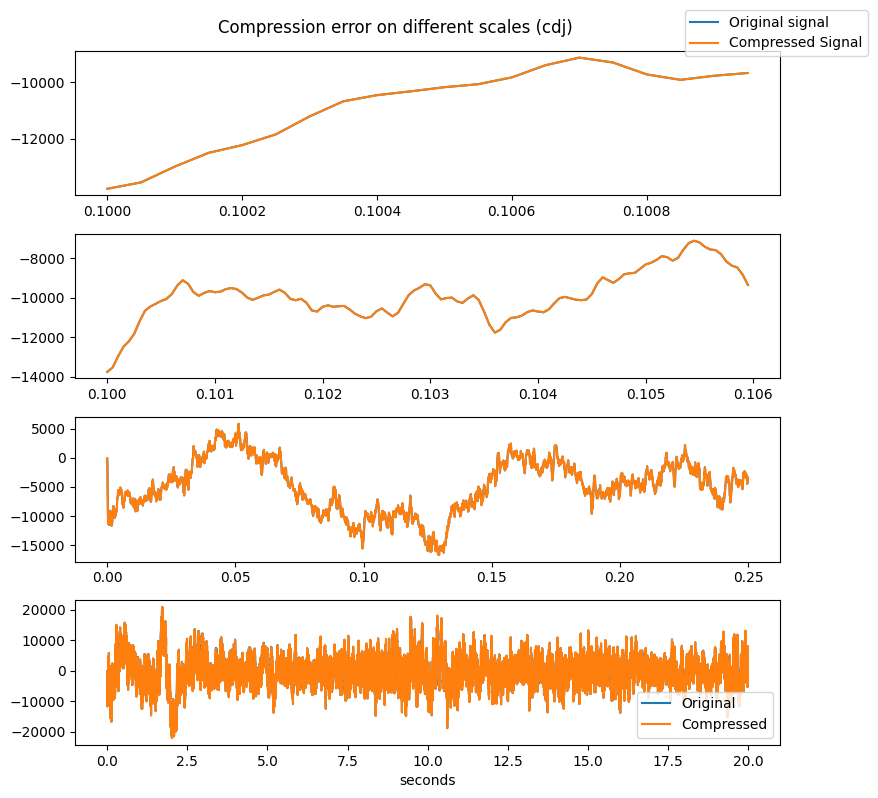

377034712


In [110]:
# Final Test on dataset 4
cdj_1 = result('cdj' , train_sig, sig1, alpha=0.5, plot=True)